In [1]:
import tensorflow as tf
import cleverhans
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastFeatureAdversaries

import numpy as np
import scipy
import keras
from keras import backend as K
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

sess = K.get_session()
K.set_session(sess)

kmodel = ResNet50(weights='imagenet')
wrap = KerasModelWrapper(kmodel)

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import *
def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

def get_img_and_process(img_path):
    img = load_img(img_path)
    img_arr = img_to_array(img)
    img_arr = img_arr[np.newaxis, :]
    img_arr = resize_img(img_arr, (224, 224, 3))
    return preprocess_input(img_arr)

vitruvian = get_img_and_process("../imgs/vitruvian.jpg")
wolf = get_img_and_process("../imgs/wolf.jpg")

In [3]:
from cleverhans.attacks import FastGradientMethod
fgsm = FastGradientMethod(wrap, sess=sess)
x_adv = fgsm.generate(kmodel.input)
x_adv = tf.stop_gradient(x_adv)
feed_dict = {kmodel.input: vitruvian}
fgsm_res = sess.run(x_adv, feed_dict=feed_dict)

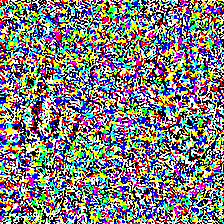

In [8]:
array_to_img(fgsm_res[0] - vitruvian[0])

In [9]:
np.argmax(kmodel.predict(fgsm_res)[0])

885

In [10]:
kmodel.predict(fgsm_res)[0, 885]

0.08221945

In [35]:
from cleverhans.attacks import CarliniWagnerL2
cwl2 = CarliniWagnerL2(model=wrap, sess=sess, targeted=True, confidence=20)
wolf_target = np.zeros((1, 1000))
wolf_target[0, 269] = 1
cwl2_args = {'y_target': wolf_target,
             'confidence': 25, 
             'learning_rate': 0.01, 
             'binary_search_steps': 10, 
             'initial_const': 0.7, 
             'clip_min': 0, 
             'clip_max': 255}
cwl2_adv = cwl2.generate(kmodel.input, **cwl2_args)
cwl2_adv = tf.stop_gradient(cwl2_adv)
feed_dict = {kmodel.input: vitruvian}
cwl2_res = sess.run(cwl2_adv, feed_dict=feed_dict)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


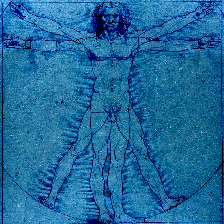

In [36]:
array_to_img(cwl2_res[0])

In [37]:
kmodel.predict(cwl2_res)[0, 549]

0.14708458

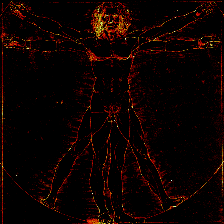

In [38]:
array_to_img(cwl2_res[0] - vitruvian[0])

In [39]:
np.argmax(kmodel.predict(cwl2_res)[0])

549

In [28]:
from cleverhans.attacks import FastFeatureAdversaries
ffa = FastFeatureAdversaries(wrap, sess=sess)
tf_ph = K.placeholder(shape=(1, 224, 224, 3))
ffa_args = {'layer': 'activation_40',
            'eps': 0.9,
            'nb_iter': 15
           }
ffa_adv = ffa.generate(kmodel.input, tf_ph, **ffa_args)
ffa_feed_dict = {kmodel.input: vitruvian, tf_ph: wolf}
ffa_res = sess.run(ffa_adv, ffa_feed_dict)

InternalError: Invalid loop structure: Mismatched parent frames for "while/while_context": "while/while_context" vs "". The node giving this error: node while/gradients/while/model_1/bn4f_branch2c/cond/FusedBatchNorm_grad/FusedBatchNormGrad/Enter_1 (defined at /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py:1887) This is an internal bug, please file a bug report with instructions on how to reproduce the error.

In [3]:
from cleverhans.attacks import SaliencyMapMethod
sma = SaliencyMapMethod(wrap, sess=sess)
wolf_target = np.zeros((1, 1000))
wolf_target[0, 269] = 1
tf_wolf_target = tf.constant(wolf_target)
sma_args = {'y_target': tf_wolf_target}
sma_adv = sma.generate(kmodel.input, **sma_args)
sma_feed_dict = {kmodel.input: vitruvian}
sma_res = sess.run(sma_adv, sma_feed_dict)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks_tf.py:356: UserWarning: Downcasting labels---this should be harmless unless they are smoothed
  warnings.warn("Downcasting labels---this should be harmless unless"


MemoryError: 

In [6]:
from cleverhans.attacks import LBFGS
wolf_target = np.zeros((1, 1000))
wolf_target[0, 269] = 1
lbfgs = LBFGS(wrap, sess=sess)
lbfgs_args = {'y_target': wolf_target}
lbfgs_adv = lbfgs.generate(kmodel.input, **lbfgs_args)
lbfgs_adv = tf.stop_gradient(lbfgs_adv)
lbfgs_feed_dict = {kmodel.input: vitruvian}
lbfgs_res = sess.run(lbfgs_adv, feed_dict=lbfgs_feed_dict)

InvalidArgumentError: TypeError: unhashable type: 'numpy.ndarray'
Traceback (most recent call last):

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 206, in __call__
    ret = func(*args)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py", line 1548, in lbfgs_wrap
    return np.array(attack.attack(x_val, y_val), dtype=self.np_dtype)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py", line 1698, in attack
    iprint=0)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 199, in fmin_l_bfgs_b
    **opts)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 335, in _minimize_lbfgsb
    f, g = func_and_grad(x)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 285, in func_and_grad
    f = fun(x, *args)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 293, in function_wrapper
    return function(*(wrapper_args + args))

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 63, in __call__
    fg = self.fun(x, *args)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py", line 1653, in lbfgs_objective
    self.const: CONST

TypeError: unhashable type: 'numpy.ndarray'


	 [[node PyFunc_1 (defined at /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py:1550)  = PyFunc[Tin=[DT_FLOAT, DT_DOUBLE], Tout=[DT_FLOAT], token="pyfunc_1", _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_input_1_0_0, PyFunc_1/input_1)]]

Caused by op 'PyFunc_1', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-95ab56c3647d>", line 6, in <module>
    lbfgs_adv = lbfgs.generate(kmodel.input, **lbfgs_args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py", line 1550, in generate
    wrap = tf.py_func(lbfgs_wrap, [x, self.y_target], self.tf_dtype)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 457, in py_func
    func=func, inp=inp, Tout=Tout, stateful=stateful, eager=False, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 281, in _internal_py_func
    input=inp, token=token, Tout=Tout, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_script_ops.py", line 129, in py_func
    "PyFunc", input=input, token=token, Tout=Tout, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): TypeError: unhashable type: 'numpy.ndarray'
Traceback (most recent call last):

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 206, in __call__
    ret = func(*args)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py", line 1548, in lbfgs_wrap
    return np.array(attack.attack(x_val, y_val), dtype=self.np_dtype)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py", line 1698, in attack
    iprint=0)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 199, in fmin_l_bfgs_b
    **opts)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 335, in _minimize_lbfgsb
    f, g = func_and_grad(x)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 285, in func_and_grad
    f = fun(x, *args)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 293, in function_wrapper
    return function(*(wrapper_args + args))

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 63, in __call__
    fg = self.fun(x, *args)

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py", line 1653, in lbfgs_objective
    self.const: CONST

TypeError: unhashable type: 'numpy.ndarray'


	 [[node PyFunc_1 (defined at /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py:1550)  = PyFunc[Tin=[DT_FLOAT, DT_DOUBLE], Tout=[DT_FLOAT], token="pyfunc_1", _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_input_1_0_0, PyFunc_1/input_1)]]


In [7]:
from cleverhans.attacks import FastGradientMethod
fgsm = FastGradientMethod(wrap, sess=sess)
x_adv = fgsm.generate(kmodel.input, y_target=wolf_target)
x_adv = tf.stop_gradient(x_adv)
feed_dict = {kmodel.input: vitruvian}
fgsm_res = sess.run(x_adv, feed_dict=feed_dict)

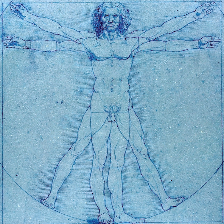

In [10]:
array_to_img(fgsm_res[0])

In [12]:
np.argmax(kmodel.predict(fgsm_res))

695

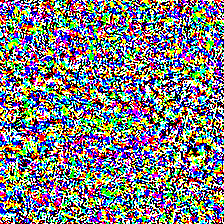

In [14]:
array_to_img((fgsm_res - vitruvian)[0])

In [3]:
from cleverhans.attacks import MomentumIterativeMethod
mim = MomentumIterativeMethod(model=wrap, sess=sess)
wolf_target = np.zeros((1, 1000))
wolf_target[0, 269] = 1
mim_args = {'y_target': wolf_target,
            'eps': 0.9, 
            'nb_iter': 50}
mim_adv = mim.generate(kmodel.input, **mim_args)
mim_adv = tf.stop_gradient(mim_adv)
feed_dict = {kmodel.input: vitruvian}
mim_res = sess.run(mim_adv, feed_dict=feed_dict)

InternalError: Invalid loop structure: Mismatched parent frames for "while/while_context": "while/while_context" vs "". The node giving this error: node while/gradients/while/model_1/bn5c_branch2c/cond/FusedBatchNorm_grad/FusedBatchNormGrad/Enter_1 (defined at /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/cleverhans/attacks/__init__.py:797) This is an internal bug, please file a bug report with instructions on how to reproduce the error.